# Process data

In [ ]:
import gzip
import json
import math
import random
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm  

# Process entire dataset if needed

def process_reviews():
    dataset = []
    path = "Electronics.jsonl.gz"

    with gzip.open(path, 'rt', encoding="utf8") as f:
        total_lines = sum(1 for _ in f)

    with gzip.open(path, 'rt', encoding="utf8") as f:
        for line in tqdm(f, total=total_lines, desc="Processing reviews"):
            d = json.loads(line.strip())
            processed_review = {
                'user_id': d['user_id'],
                'rating': int(float(d['rating'])),
                'helpful_vote': int(d['helpful_vote']),
                'timestamp': int(d['timestamp']),
                'asin': d['asin'],
                'text': d['text'],
                'title': d['title'],
                'parent_asin': d['parent_asin'],
                'verified_purchase': d['verified_purchase']
            }
            dataset.append(processed_review)
    
    return dataset

# Process sample of dataset

def process_reviews_sample(sample_size=100000):
   dataset = []
   path = "Electronics.jsonl.gz"
   
   with gzip.open(path, 'rt', encoding="utf8") as f:
       for i, line in tqdm(enumerate(f), total=sample_size, desc="Processing sample"):
           if i >= sample_size:
               break
           d = json.loads(line.strip())
           processed_review = {
               'user_id': d['user_id'],
               'rating': int(float(d['rating'])),
               'helpful_vote': int(d['helpful_vote']),
               'timestamp': int(d['timestamp']),
               'asin': d['asin'],
               'text': d['text'],
               'title': d['title'],
               'parent_asin': d['parent_asin'],
               'verified_purchase': d['verified_purchase']
           }
           dataset.append(processed_review)
   
   return dataset

# Process and save full dataset

full_dataset = process_reviews()
df = pd.DataFrame(full_dataset)
df.to_parquet('processed_electronics.parquet')

Processing reviews: 100%|██████████████████████████████████████████████| 43886944/43886944 [06:05<00:00, 120045.94it/s]


In [ ]:
import gzip
import json
import pandas as pd
from tqdm import tqdm

def process_and_save_reviews(chunk_size=50000):
    """
    Process and save the data in smaller chunks to manage memory
    """
    path = "Electronics.jsonl.gz"
    chunk_counter = 0
    chunk = []
    
    # First count total lines
    print("Counting total lines...")
    with gzip.open(path, 'rt', encoding="utf8") as f:
        total_lines = sum(1 for _ in f)
    
    print(f"Processing {total_lines:,} reviews in chunks of {chunk_size:,}")
    
    # Process in chunks
    with gzip.open(path, 'rt', encoding="utf8") as f:
        for i, line in tqdm(enumerate(f), total=total_lines):
            d = json.loads(line.strip())
            processed_review = {
                'user_id': d['user_id'],
                'rating': int(float(d['rating'])),
                'helpful_vote': int(d['helpful_vote']),
                'timestamp': int(d['timestamp']),
                'asin': d['asin'],
                'text': d['text'],
                'title': d.get('title', ''),
                'parent_asin': d.get('parent_asin', ''),
                'verified_purchase': d['verified_purchase']
            }
            chunk.append(processed_review)
            
            # Save chunk when it reaches the chunk_size
            if len(chunk) >= chunk_size:
                df = pd.DataFrame(chunk)
                df.to_parquet(f'chunks/chunk_{chunk_counter}.parquet')
                chunk = []  # Clear chunk
                chunk_counter += 1
                
    # Save any remaining reviews
    if chunk:
        df = pd.DataFrame(chunk)
        df.to_parquet(f'chunk_{chunk_counter}.parquet')
    
    print(f"Processing complete! Saved {chunk_counter + 1} chunks.")

# Run the processing
process_and_save_reviews()

Counting total lines...
Processing 43,886,944 reviews in chunks of 50,000


 71%|███████████████████████████████████████████████████████████████████████████▌                               | 30977334/43886944 [03:08<01:09, 184462.93it/s]

In [4]:
import glob

# Get all chunk files from the chunks folder
chunks = glob.glob('chunks/chunk_*.parquet')
# Load and combine all chunks
df = pd.concat([pd.read_parquet(f) for f in chunks])

# Exploratory analysis

Loading chunks...
Loaded 877 chunks, total 43,850,000 reviews

Basic Statistics:
count    4.385000e+07
mean     4.099481e+00
std      1.412131e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


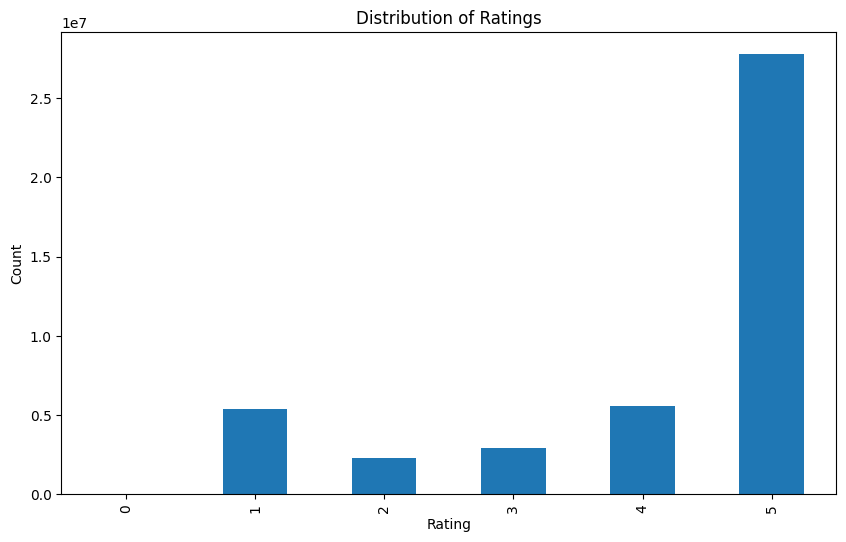

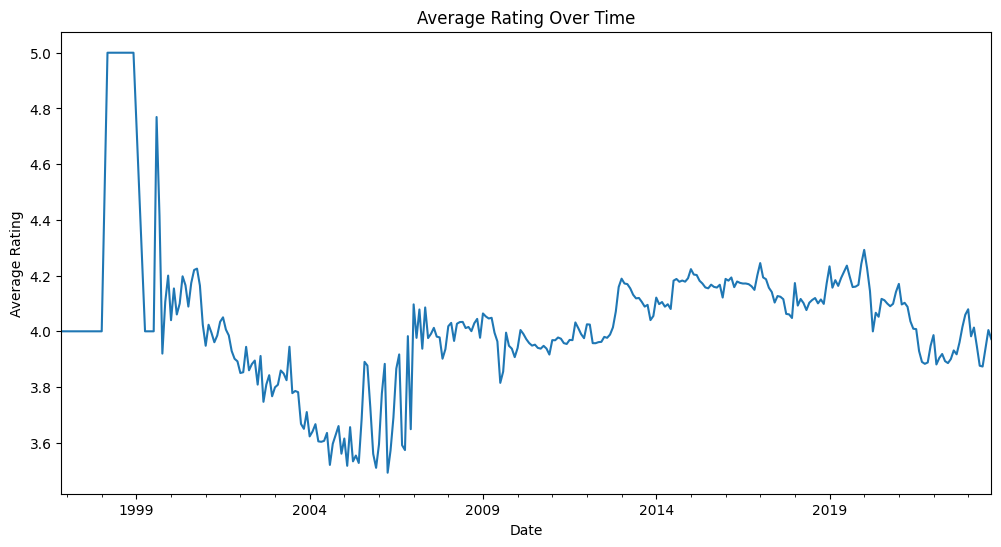


Helpful Votes Statistics:
count    4.385000e+07
mean     1.090535e+00
std      2.258447e+01
min     -4.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.684100e+04
Name: helpful_vote, dtype: float64

Average Rating by Verified Purchase:
verified_purchase
False    3.822335
True     4.122305
Name: rating, dtype: float64

User Review Statistics:
count    1.825637e+07
mean     2.401901e+00
std      3.927539e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.034000e+03
Name: count, dtype: float64


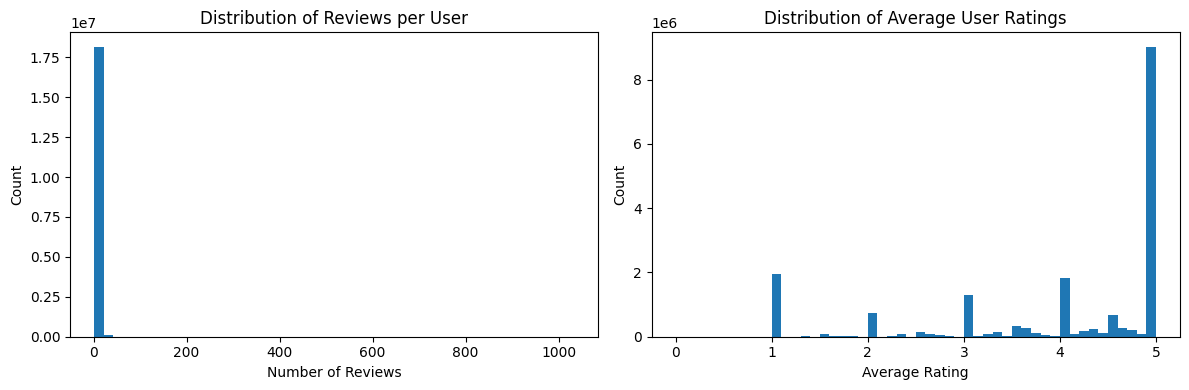

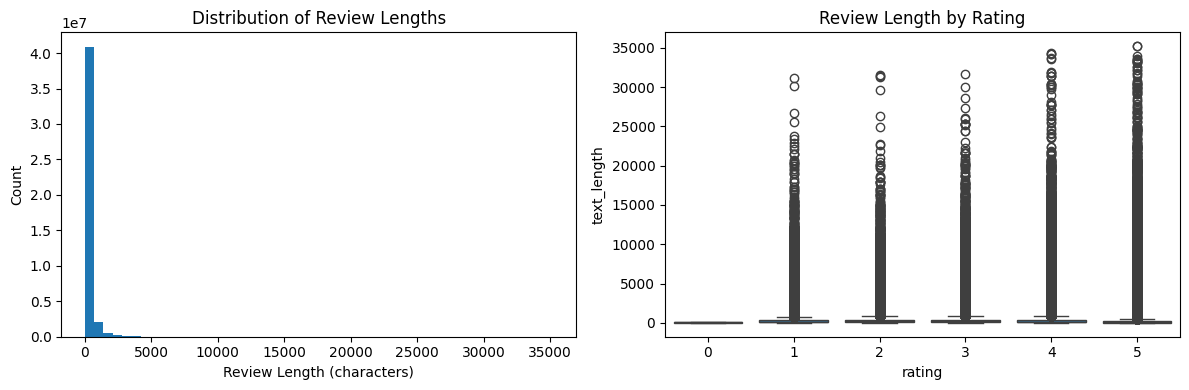


Text Length Statistics:
count    4.385000e+07
mean     2.413575e+02
std      4.194510e+02
min      0.000000e+00
25%      4.800000e+01
50%      1.220000e+02
75%      2.710000e+02
max      3.520800e+04
Name: text_length, dtype: float64

Correlation between review length and helpful votes: 0.132


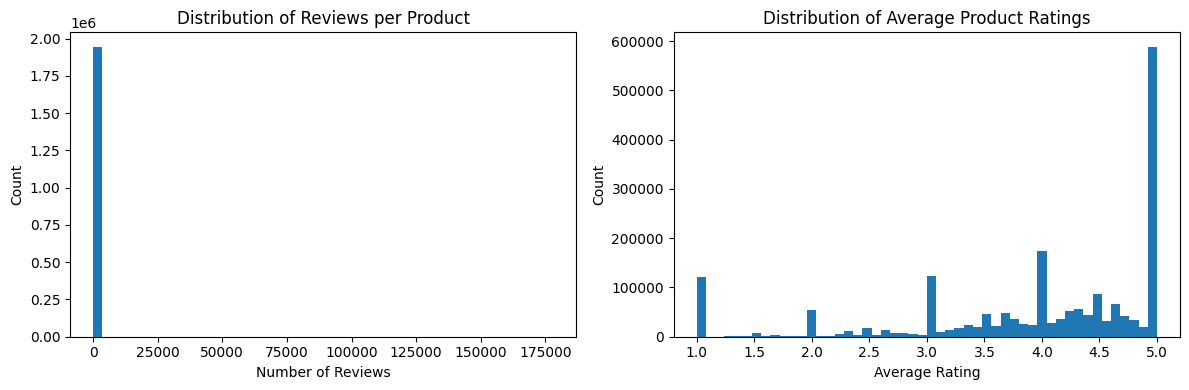


Product Statistics:
Total unique products: 1946011

Reviews per product:
count    1.946011e+06
mean     2.253327e+01
std      2.809363e+02
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      1.780510e+05
Name: count, dtype: float64


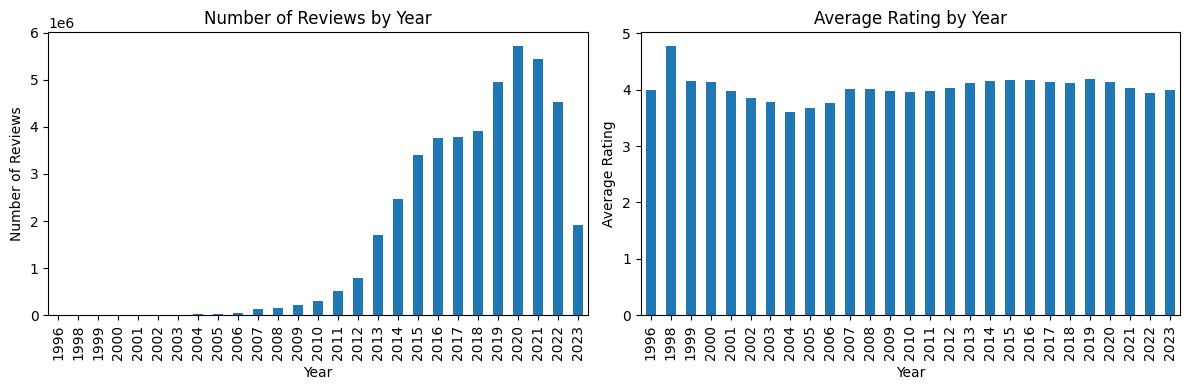


Verified Purchase Analysis:
                     rating             helpful_vote text_length
                      count  mean   std         mean        mean
verified_purchase                                               
False               3336515  3.82  1.53         2.46      539.14
True               40513485  4.12  1.40         0.98      216.83

Overall Summary Statistics:
Total Reviews: 43850000.00
Unique Users: 18256370.00
Unique Products: 1946011.00
Average Rating: 4.10
Median Rating: 5.00
Average Review Length: 241.36
Verified Purchase %: 0.00
Average Helpful Votes: 1.09


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Load all chunks from the chunks folder
print("Loading chunks...")
chunks = glob.glob('chunks/chunk_*.parquet')
df = pd.concat([pd.read_parquet(f) for f in chunks], ignore_index=True)
print(f"Loaded {len(chunks)} chunks, total {len(df):,} reviews")

# The rest of your analysis code remains the same, just remove the DataFrame conversion
# since we already have a DataFrame

# Basic statistics
print("\nBasic Statistics:")
print(df['rating'].describe())

# Rating distribution
plt.figure(figsize=(10, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Average rating over time
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
monthly_ratings = df.groupby(df['date'].dt.to_period('M'))['rating'].mean()
plt.figure(figsize=(12, 6))
monthly_ratings.plot(kind='line')
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.show()

# Helpful votes analysis
print("\nHelpful Votes Statistics:")
print(df['helpful_vote'].describe())

# Verified vs unverified purchase ratings
print("\nAverage Rating by Verified Purchase:")
print(df.groupby('verified_purchase')['rating'].mean())

# User Analysis
user_review_counts = df['user_id'].value_counts()
user_avg_ratings = df.groupby('user_id')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(user_review_counts, bins=50)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
print("\nUser Review Statistics:")
print(user_review_counts.describe())

plt.subplot(1, 2, 2)
plt.hist(user_avg_ratings, bins=50)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Review Text Analysis
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='text_length', data=df)
plt.title('Review Length by Rating')
plt.tight_layout()
plt.show()

print("\nText Length Statistics:")
print(df['text_length'].describe())

# Correlation between text length and helpful votes
correlation = df['text_length'].corr(df['helpful_vote'])
print(f"\nCorrelation between review length and helpful votes: {correlation:.3f}")

# Product Analysis
product_review_counts = df['asin'].value_counts()
product_avg_ratings = df.groupby('asin')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(product_review_counts, bins=50)
plt.title('Distribution of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(product_avg_ratings, bins=50)
plt.title('Distribution of Average Product Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nProduct Statistics:")
print(f"Total unique products: {df['asin'].nunique()}")
print("\nReviews per product:")
print(product_review_counts.describe())

# Time analysis
df['year'] = df['date'].dt.year
yearly_counts = df.groupby('year').size()
yearly_ratings = df.groupby('year')['rating'].mean()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
yearly_counts.plot(kind='bar')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
yearly_ratings.plot(kind='bar')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

# Verified Purchase Analysis
verified_stats = df.groupby('verified_purchase').agg({
    'rating': ['count', 'mean', 'std'],
    'helpful_vote': 'mean',
    'text_length': 'mean'
}).round(2)

print("\nVerified Purchase Analysis:")
print(verified_stats)

# Overall Summary Statistics
summary_stats = {
    'Total Reviews': len(df),
    'Unique Users': df['user_id'].nunique(),
    'Unique Products': df['asin'].nunique(),
    'Average Rating': df['rating'].mean(),
    'Median Rating': df['rating'].median(),
    'Average Review Length': df['text_length'].mean(),
    'Verified Purchase %': (df['verified_purchase'] == 'Y').mean() * 100,
    'Average Helpful Votes': df['helpful_vote'].mean()
}

print("\nOverall Summary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value:.2f}")

# The Predictor

In [93]:
import gzip
import math
import matplotlib.pyplot as plt
import numpy
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
#from transformers import AutoTokenizer, AutoModel

In [ ]:
# 1% of the dataframe as a python list. otherwise it's too big.
sampled_df = df.sample(n=int(0.5 * len(df)))

# Convert the sampled DataFrame to a list of lists
rawData = sampled_df.values.tolist()
data = []
for i in rawData:
    data.append({
        "user_id": i[0],
        "rating": i[1],
        "helpful_vote": i[2],
        "timestamp": i[3],
        "asin": i[4],
        "text": i[5],
        "title": i[6],
        "parent_asin": i[7],
        "verified_purchase": i[8],
        "date": i[9],
        "text_length": i[10],
        "year": i[11]
    })


In [ ]:
reviews = [d['text'] for d in data] #array of each review's text.
ratings = [d['rating'] for d in data] #array of each review's rating.

In [ ]:
reviewTokens = [] #lists the token words for each review.

In [ ]:
punctuation = set(string.punctuation)
for r in reviews:
    r = ''.join([c for c in r.lower() if not c in punctuation])
    tokens = []
    for w in r.split():
        tokens.append(w)
    reviewTokens.append(tokens)

In [ ]:
model = Word2Vec(reviewTokens,
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [ ]:
def get_doc_vector(review, model_w2v):
    vectors = [model_w2v.wv[word] for word in review if word in model_w2v.wv]
    return numpy.mean(vectors, axis=0) if vectors else numpy.zeros(model_w2v.vector_size)

In [ ]:
feature_vector = [get_doc_vector(review, model) for review in reviews]

In [ ]:
X = [[1]+list(f) for f in feature_vector]

X_train, X_test, y_train, y_test = train_test_split(X, ratings, test_size=0.2, random_state=42)
model_lr = sklearn.linear_model.Ridge(1, fit_intercept=False)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 

In [ ]:
model_lr.coef_

In [ ]:
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"  # Choose a pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

text = "This is an example sentence."
inputs = tokenizer(text, return_tensors="pt") 
outputs = model(**inputs)
embeddings = outputs.last_hidden_state  # Access the embeddings